In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Make Input

In [3]:
def calculateWeight(tlx):
    tlx_weight = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Sum':[0]}
    tlx_weight = pd.DataFrame(tlx_weight)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col1 in range(1,len(tlx.columns)):
            for col2 in range(col1+1, len(tlx.columns)):
                if tlx[tlx.columns[col1]][i] > tlx[tlx.columns[col2]][i]:
                    score[col1-1]+=1
                elif tlx[tlx.columns[col1]][i] < tlx[tlx.columns[col2]][i]:
                    score[col2-1]+=1
                else :
                    score[col1-1]+=0.5
                    score[col2-1]+=0.5
                    
        score[6] = score[0]+score[1]+score[2]+score[3]+score[4]+score[5]
        tlx_weight.loc[i]=score
    #print(tlx_weight.loc[0])
    return tlx_weight

def calculate_tlxLevel(tlx, tlx_weight):
    result = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Score':[0]}
    result = pd.DataFrame(result)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col in range(len(tlx_weight.columns)-1):
            score[col] = int(tlx[tlx.columns[col+1]].loc[i] * tlx_weight[tlx_weight.columns[col]].loc[i] )
        score[6] =int((score[0]+score[1]+score[2]+score[3]+score[4]+score[5] )/ tlx_weight[tlx_weight.columns[6]].loc[i]/10 + 0.5)
        if score[6]>10: score[6]=10
        if score[6]<0: score[6]=0
        result.loc[i]=score
    return result['Score']

In [4]:
def split_fft_data(df, label, end):
    col = ['POW.AF3.Theta', 'POW.AF3.Alpha',
       'POW.AF3.BetaL', 'POW.AF3.BetaH', 'POW.AF3.Gamma', 'POW.F7.Theta',
       'POW.F7.Alpha', 'POW.F7.BetaL', 'POW.F7.BetaH', 'POW.F7.Gamma',
       'POW.F3.Theta', 'POW.F3.Alpha', 'POW.F3.BetaL', 'POW.F3.BetaH',
       'POW.F3.Gamma', 'POW.FC5.Theta', 'POW.FC5.Alpha', 'POW.FC5.BetaL',
       'POW.FC5.BetaH', 'POW.FC5.Gamma', 'POW.T7.Theta', 'POW.T7.Alpha',
       'POW.T7.BetaL', 'POW.T7.BetaH', 'POW.T7.Gamma', 'POW.P7.Theta',
       'POW.P7.Alpha', 'POW.P7.BetaL', 'POW.P7.BetaH', 'POW.P7.Gamma',
       'POW.O1.Theta', 'POW.O1.Alpha', 'POW.O1.BetaL', 'POW.O1.BetaH',
       'POW.O1.Gamma', 'POW.O2.Theta', 'POW.O2.Alpha', 'POW.O2.BetaL',
       'POW.O2.BetaH', 'POW.O2.Gamma', 'POW.P8.Theta', 'POW.P8.Alpha',
       'POW.P8.BetaL', 'POW.P8.BetaH', 'POW.P8.Gamma', 'POW.T8.Theta',
       'POW.T8.Alpha', 'POW.T8.BetaL', 'POW.T8.BetaH', 'POW.T8.Gamma',
       'POW.FC6.Theta', 'POW.FC6.Alpha', 'POW.FC6.BetaL', 'POW.FC6.BetaH',
       'POW.FC6.Gamma', 'POW.F4.Theta', 'POW.F4.Alpha', 'POW.F4.BetaL',
       'POW.F4.BetaH', 'POW.F4.Gamma', 'POW.F8.Theta', 'POW.F8.Alpha',
       'POW.F8.BetaL', 'POW.F8.BetaH', 'POW.F8.Gamma', 'POW.AF4.Theta',
       'POW.AF4.Alpha', 'POW.AF4.BetaL', 'POW.AF4.BetaH', 'POW.AF4.Gamma', 'MarkerValueInt']
    col_rename = ['AF3.Theta', 'AF3.Alpha','AF3.BetaL', 'AF3.BetaH', 'AF3.Gamma', 
                  'F7.Theta','F7.Alpha', 'F7.BetaL', 'F7.BetaH', 'F7.Gamma',
                  'F3.Theta', 'F3.Alpha', 'F3.BetaL', 'F3.BetaH','F3.Gamma', 
                  'FC5.Theta', 'FC5.Alpha', 'FC5.BetaL','FC5.BetaH', 'FC5.Gamma', 
                  'T7.Theta', 'T7.Alpha', 'T7.BetaL', 'T7.BetaH', 'T7.Gamma', 
                  'P7.Theta', 'P7.Alpha', 'P7.BetaL', 'P7.BetaH', 'P7.Gamma',
                  'O1.Theta', 'O1.Alpha', 'O1.BetaL', 'O1.BetaH','O1.Gamma',
                  'O2.Theta', 'O2.Alpha', 'O2.BetaL','O2.BetaH', 'O2.Gamma',
                  'P8.Theta', 'P8.Alpha', 'P8.BetaL', 'P8.BetaH', 'P8.Gamma', 
                  'T8.Theta','T8.Alpha', 'T8.BetaL', 'T8.BetaH', 'T8.Gamma',
                  'FC6.Theta', 'FC6.Alpha', 'FC6.BetaL', 'FC6.BetaH','FC6.Gamma', 
                  'F4.Theta', 'F4.Alpha', 'F4.BetaL','F4.BetaH', 'F4.Gamma',
                  'F8.Theta', 'F8.Alpha','F8.BetaL', 'F8.BetaH', 'F8.Gamma',
                  'AF4.Theta', 'AF4.Alpha', 'AF4.BetaL', 'AF4.BetaH', 'AF4.Gamma', 'vis_name']
    data_extraction = df[col]
    data_extraction.columns = col_rename
    rest = data_extraction[data_extraction.vis_name == 0].dropna(axis=0)
    survey = data_extraction[data_extraction.vis_name == 100].dropna(axis=0)
    
    vis = data_extraction[data_extraction.vis_name == 1].reset_index(drop=True).dropna(axis=0)
    vis['label'] = label[0]
    vis.drop(['vis_name'], axis=1, inplace=True)
    
    for i in range(2,end):
        df = data_extraction[data_extraction.vis_name == i].reset_index(drop=True)
        df['label'] = label[i-1]
        df.drop(['vis_name'], axis=1, inplace=True)
        df = df.dropna(axis=0)
        vis = pd.concat([vis,df], ignore_index=True, axis=0)
    return rest, survey, vis

In [5]:
src = 'C:/EEG data/User/'
files = os.listdir(src)
tlx=[]
for f in files:
    tlx.append(pd.read_csv(src+f))
src = 'C:/EEG data/prepross/'
datas = os.listdir(src)
workloadLevel = []
for t in tlx:
    workloadLevel.append(calculate_tlxLevel(t, calculateWeight(t)))
eegData=[]
for d in datas:
    eegData.append(pd.read_csv(src+d))

In [6]:
cnt = 0
for eeg, label in zip (eegData, workloadLevel):
    if cnt == 0 :
        rest, survey, vis = split_fft_data(eeg, label,21)
        cnt+=1
        continue
    elif cnt == 6:
        r, s, v = split_fft_data(eeg, label,21)
    else:
        r, s, v = split_fft_data(eeg, label, 22)
    
    rest = pd.concat([rest,r], ignore_index=True, axis=0)
    survey = pd.concat([survey,s], ignore_index=True, axis=0)
    vis = pd.concat([vis,v], ignore_index=True, axis=0)
    cnt+=1

In [10]:
label=vis['label']
label = to_categorical(label,11)
data=vis.drop(['label'],axis=1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data
print(data.shape, label.shape)

(108212, 70) (108212, 11)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(data,label, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = label)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y_test)

print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(64927, 70) (21642, 70) (21643, 70) (64927, 11) (21642, 11) (21643, 11)


# Model Tuning

In [19]:
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(bbox_to_anchor=(1.05, 1))

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(bbox_to_anchor=(1.05, 0))

    plt.show()

In [18]:
from sklearn.metrics import f1_score

def runModel(name, model, crossentropy, x_train, y_train, x_valid, y_valid):
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        epochs = 300, 
                        validation_data = (x_valid, y_valid), 
                        callbacks=[early_stop], verbose=1)
    drawResult(history)
    
    return model
    
def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

In [9]:
import autokeras as ak
from tensorflow.keras.utils import plot_model
from datetime import datetime

from autokeras.keras_layers import ExpandLastDim, MultiCategoryEncoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import EfficientNetB7
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [15]:
from tensorflow.keras.models import load_model

model_path = 'model/FFT_ACC__83_try_50'
loaded_model = load_model(model_path)
loaded_model.summary()
loaded_model.get_config()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 70)                0         
_________________________________________________________________
normalization (Normalization (None, 70)                141       
_________________________________________________________________
dense (Dense)                (None, 1024)              72704     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0     

# DNN

Epoch 1/300
2029/2029 [==============================] - 7s 3ms/step - loss: 1.5829 - accuracy: 0.3677 - val_loss: 1.4905 - val_accuracy: 0.3950
Epoch 2/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.3646 - accuracy: 0.4508 - val_loss: 1.3173 - val_accuracy: 0.4700
Epoch 3/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2457 - accuracy: 0.4881 - val_loss: 1.2231 - val_accuracy: 0.5076
Epoch 4/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.1804 - accuracy: 0.5121 - val_loss: 1.1639 - val_accuracy: 0.5199
Epoch 5/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.1351 - accuracy: 0.5287 - val_loss: 1.1322 - val_accuracy: 0.5274
Epoch 6/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.1000 - accuracy: 0.5429 - val_loss: 1.0915 - val_accuracy: 0.5540
Epoch 7/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.0726 - accuracy: 0.5504 - val_loss: 1.0701 - val_ac

2029/2029 [==============================] - 6s 3ms/step - loss: 0.2739 - accuracy: 0.8951 - val_loss: 0.3808 - val_accuracy: 0.8560
Epoch 114/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2766 - accuracy: 0.8963 - val_loss: 0.4086 - val_accuracy: 0.8472
Epoch 115/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2630 - accuracy: 0.9001 - val_loss: 0.3777 - val_accuracy: 0.8550
Epoch 116/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2648 - accuracy: 0.8981 - val_loss: 0.3689 - val_accuracy: 0.8611
Epoch 117/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2657 - accuracy: 0.8997 - val_loss: 0.3601 - val_accuracy: 0.8626
Epoch 118/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2576 - accuracy: 0.9025 - val_loss: 0.3910 - val_accuracy: 0.8494
Epoch 119/300
2029/2029 [==============================] - 6s 3ms/step - loss: 0.2615 - accuracy: 0.9019 - val_loss: 0.3843 - val_ac

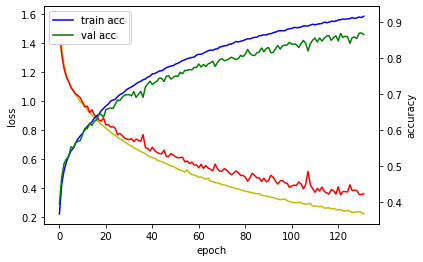

0.88779910019145

In [53]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    #MultiCategoryEncoding
    #Normailzation
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

f1_score_DNN = eval_model(runModel('DNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)
f1_score_DNN

Epoch 1/300
2029/2029 [==============================] - 7s 3ms/step - loss: 1.5863 - accuracy: 0.3626 - val_loss: 1.4508 - val_accuracy: 0.4095
Epoch 2/300
2029/2029 [==============================] - 7s 3ms/step - loss: 1.3591 - accuracy: 0.4518 - val_loss: 1.3618 - val_accuracy: 0.4580
Epoch 3/300
2029/2029 [==============================] - 7s 3ms/step - loss: 1.2410 - accuracy: 0.4910 - val_loss: 1.2105 - val_accuracy: 0.5017
Epoch 4/300
2029/2029 [==============================] - 7s 3ms/step - loss: 1.1760 - accuracy: 0.5123 - val_loss: 1.1852 - val_accuracy: 0.5121
Epoch 5/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.1293 - accuracy: 0.5316 - val_loss: 1.1226 - val_accuracy: 0.5350
Epoch 6/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.0938 - accuracy: 0.5452 - val_loss: 1.0932 - val_accuracy: 0.5480
Epoch 7/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.0678 - accuracy: 0.5545 - val_loss: 1.0735 - val_ac

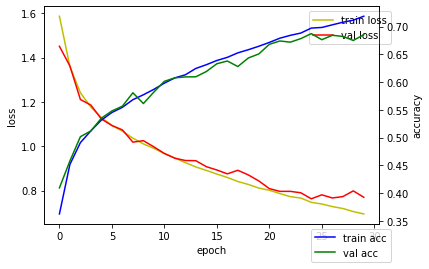

{'name': 'sequential_13',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 70),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_14'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_12',
    'trainable': True,
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_13',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros'

In [35]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    #MultiCategoryEncoding
    #Normailzation
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='softmax'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

model = runModel('DNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid)
f1_score_DNN = eval_model(model, x_test, y_test)

model.get_config()

In [36]:
f1_score_DNN

0.7076137731166933

# 1D CNN

Epoch 1/300
2029/2029 [==============================] - 29s 12ms/step - loss: 1.8280 - accuracy: 0.2511 - val_loss: 1.7926 - val_accuracy: 0.2501
Epoch 2/300
2029/2029 [==============================] - 25s 12ms/step - loss: 1.7708 - accuracy: 0.2693 - val_loss: 1.7300 - val_accuracy: 0.2969
Epoch 3/300
2029/2029 [==============================] - 25s 12ms/step - loss: 1.7189 - accuracy: 0.3028 - val_loss: 1.6855 - val_accuracy: 0.3250
Epoch 4/300
2029/2029 [==============================] - 25s 12ms/step - loss: 1.6886 - accuracy: 0.3149 - val_loss: 1.6582 - val_accuracy: 0.3259
Epoch 5/300
2029/2029 [==============================] - 25s 12ms/step - loss: 1.6658 - accuracy: 0.3233 - val_loss: 1.6466 - val_accuracy: 0.3490
Epoch 6/300
2029/2029 [==============================] - 25s 13ms/step - loss: 1.6460 - accuracy: 0.3338 - val_loss: 1.6225 - val_accuracy: 0.3508
Epoch 7/300
2029/2029 [==============================] - 25s 12ms/step - loss: 1.6303 - accuracy: 0.3394 - val_loss: 1

2029/2029 [==============================] - 26s 13ms/step - loss: 1.2226 - accuracy: 0.4973 - val_loss: 1.1593 - val_accuracy: 0.5183
Epoch 112/300
2029/2029 [==============================] - 26s 13ms/step - loss: 1.2260 - accuracy: 0.4920 - val_loss: 1.1520 - val_accuracy: 0.5291
Epoch 113/300
2029/2029 [==============================] - 26s 13ms/step - loss: 1.2259 - accuracy: 0.4934 - val_loss: 1.1675 - val_accuracy: 0.5226
Epoch 114/300
2029/2029 [==============================] - 26s 13ms/step - loss: 1.2266 - accuracy: 0.4958 - val_loss: 1.1572 - val_accuracy: 0.5229


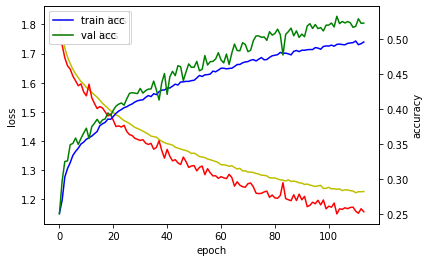

In [58]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024,3, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 3, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_1 = eval_model(runModel('CNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [59]:
f1_score_CNN_1

0.48985697407539347

In [34]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024, 2, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 2, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_2 = eval_model(runModel('CNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

Epoch 1/300
2029/2029 [==============================] - 181s 89ms/step - loss: 1.8820 - accuracy: 0.2435 - val_loss: 1.8416 - val_accuracy: 0.2461
Epoch 2/300
2029/2029 [==============================] - 181s 89ms/step - loss: 1.8359 - accuracy: 0.2515 - val_loss: 1.8148 - val_accuracy: 0.2609
Epoch 3/300
2029/2029 [==============================] - 178s 88ms/step - loss: 1.8058 - accuracy: 0.2661 - val_loss: 1.7808 - val_accuracy: 0.2791
Epoch 4/300
2029/2029 [==============================] - 178s 88ms/step - loss: 1.7831 - accuracy: 0.2714 - val_loss: 1.7682 - val_accuracy: 0.2809
Epoch 5/300
2029/2029 [==============================] - 178s 88ms/step - loss: 1.7696 - accuracy: 0.2763 - val_loss: 1.7494 - val_accuracy: 0.2830
Epoch 6/300
2029/2029 [==============================] - 178s 88ms/step - loss: 1.7566 - accuracy: 0.2851 - val_loss: 1.7419 - val_accuracy: 0.2901
Epoch 7/300
2029/2029 [==============================] - 178s 88ms/step - loss: 1.7434 - accuracy: 0.2907 - val_

KeyboardInterrupt: 

In [ ]:
loaded_model.get_config()

In [ ]:
f1_score_CNN_2

# LSTM

Epoch 1/300
2029/2029 [==============================] - 649s 318ms/step - loss: 1.8790 - accuracy: 0.2363 - val_loss: 1.8731 - val_accuracy: 0.2451
Epoch 2/300
2029/2029 [==============================] - 634s 313ms/step - loss: 1.8732 - accuracy: 0.2411 - val_loss: 1.8743 - val_accuracy: 0.2451
Epoch 3/300
2029/2029 [==============================] - 638s 314ms/step - loss: 1.8726 - accuracy: 0.2435 - val_loss: 1.8706 - val_accuracy: 0.2451
Epoch 4/300
2029/2029 [==============================] - 640s 316ms/step - loss: 1.8723 - accuracy: 0.2440 - val_loss: 1.8720 - val_accuracy: 0.2451
Epoch 5/300
2029/2029 [==============================] - 640s 316ms/step - loss: 1.8723 - accuracy: 0.2437 - val_loss: 1.8708 - val_accuracy: 0.2451
Epoch 6/300
2029/2029 [==============================] - 643s 317ms/step - loss: 1.8717 - accuracy: 0.2433 - val_loss: 1.8730 - val_accuracy: 0.2451
Epoch 7/300
2029/2029 [==============================] - 644s 317ms/step - loss: 1.8718 - accuracy: 0.2441

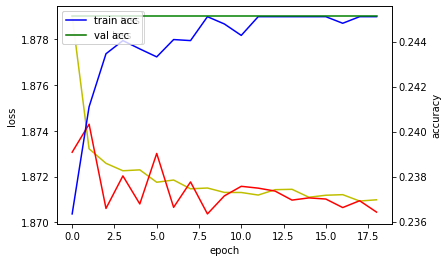

Epoch 1/300
2029/2029 [==============================] - 654s 321ms/step - loss: 1.8793 - accuracy: 0.2391 - val_loss: 1.8724 - val_accuracy: 0.2451
Epoch 2/300
2029/2029 [==============================] - 643s 317ms/step - loss: 1.8731 - accuracy: 0.2419 - val_loss: 1.8722 - val_accuracy: 0.2451
Epoch 3/300
2029/2029 [==============================] - 687s 339ms/step - loss: 1.8724 - accuracy: 0.2441 - val_loss: 1.8706 - val_accuracy: 0.2451
Epoch 4/300
2029/2029 [==============================] - 695s 342ms/step - loss: 1.8722 - accuracy: 0.2440 - val_loss: 1.8714 - val_accuracy: 0.2451
Epoch 5/300
2029/2029 [==============================] - 656s 323ms/step - loss: 1.8719 - accuracy: 0.2437 - val_loss: 1.8708 - val_accuracy: 0.2451
Epoch 6/300
2029/2029 [==============================] - 645s 318ms/step - loss: 1.8718 - accuracy: 0.2448 - val_loss: 1.8705 - val_accuracy: 0.2451
Epoch 7/300
2029/2029 [==============================] - 648s 319ms/step - loss: 1.8716 - accuracy: 0.2445

KeyboardInterrupt: 

In [14]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    model.add(ExpandLastDim())
    model.add(LSTM(512))
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_LSTM = eval_model(runModel('LSTM',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [15]:
f1_score_LSTM  # 0.24

0.03937212409084162

# 1D CNN + LSTM

In [17]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024, 3, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 3, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_LSTM = eval_model(runModel('CNN_LSTM',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

Epoch 1/300
2029/2029 [==============================] - 347s 170ms/step - loss: 1.8898 - accuracy: 0.2337 - val_loss: 1.8722 - val_accuracy: 0.2451
Epoch 2/300
2029/2029 [==============================] - 379s 187ms/step - loss: 1.8759 - accuracy: 0.2422 - val_loss: 1.8704 - val_accuracy: 0.2451
Epoch 3/300
2029/2029 [==============================] - 385s 190ms/step - loss: 1.8746 - accuracy: 0.2440 - val_loss: 1.8717 - val_accuracy: 0.2451
Epoch 4/300
2029/2029 [==============================] - 386s 190ms/step - loss: 1.8745 - accuracy: 0.2446 - val_loss: 1.8713 - val_accuracy: 0.2451
Epoch 5/300
2029/2029 [==============================] - 387s 191ms/step - loss: 1.8316 - accuracy: 0.2578 - val_loss: 1.7970 - val_accuracy: 0.2716
Epoch 6/300
2029/2029 [==============================] - 391s 193ms/step - loss: 1.7972 - accuracy: 0.2676 - val_loss: 1.8076 - val_accuracy: 0.2711
Epoch 7/300
2029/2029 [==============================] - 391s 193ms/step - loss: 1.7877 - accuracy: 0.2755

Epoch 56/300
2029/2029 [==============================] - 403s 199ms/step - loss: 1.5028 - accuracy: 0.3975 - val_loss: 1.4763 - val_accuracy: 0.4101
Epoch 57/300
2029/2029 [==============================] - 398s 196ms/step - loss: 1.5024 - accuracy: 0.3973 - val_loss: 1.4878 - val_accuracy: 0.4034
Epoch 58/300
2029/2029 [==============================] - 397s 196ms/step - loss: 1.4993 - accuracy: 0.3987 - val_loss: 1.5032 - val_accuracy: 0.3940
Epoch 59/300
2029/2029 [==============================] - 395s 195ms/step - loss: 1.5083 - accuracy: 0.3959 - val_loss: 1.4977 - val_accuracy: 0.3999
Epoch 60/300
2029/2029 [==============================] - 395s 195ms/step - loss: 1.4923 - accuracy: 0.3999 - val_loss: 1.5056 - val_accuracy: 0.4016
Epoch 61/300
2029/2029 [==============================] - 394s 194ms/step - loss: 1.4900 - accuracy: 0.4027 - val_loss: 1.4934 - val_accuracy: 0.3992
Epoch 62/300
2029/2029 [==============================] - 393s 194ms/step - loss: 1.4883 - accuracy:

KeyboardInterrupt: 

In [ ]:
f1_score_CNN_LSTM

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024,2, padding='valid', activation='relu'))
    model.add(Dropout(0.15))
    model.add(Conv1D(512, 2, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_3 = eval_model(runModel('CNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)
f1_score_CNN_3

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    #MultiCategoryEncoding
    #Normailzation
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

f1_score_DNN1 = eval_model(runModel('DNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)
f1_score_DNN1

# windowing LSTM

In [31]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size):
        data_list.append(np.array(data.iloc[i*window_size:(i+1)*window_size]))
        label_list.append(np.array(label.iloc[i*window_size]))
    return np.array(data_list), np.array(label_list)

data_l, label_l = windowing_dataset(data,pd.DataFrame(label),14)
X_train, X_test, Y_train, Y_test = train_test_split(data_l,label_l, 
                                                    train_size=0.6, 
                                                    random_state=True,
                                                    stratify = label_l)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, 
                                                    train_size=0.5, 
                                                    random_state=True,
                                                    stratify = Y_test)

print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(4637, 14, 70) (1546, 14, 70) (1546, 14, 70) (4637, 11) (1546, 11) (1546, 11)


Epoch 1/300
145/145 [==============================] - 31s 192ms/step - loss: 1.9450 - accuracy: 0.2243 - val_loss: 1.8844 - val_accuracy: 0.1850
Epoch 2/300
145/145 [==============================] - 27s 187ms/step - loss: 1.8794 - accuracy: 0.2310 - val_loss: 1.8737 - val_accuracy: 0.2451
Epoch 3/300
145/145 [==============================] - 27s 186ms/step - loss: 1.8791 - accuracy: 0.2338 - val_loss: 1.8720 - val_accuracy: 0.2451
Epoch 4/300
145/145 [==============================] - 27s 187ms/step - loss: 1.8781 - accuracy: 0.2361 - val_loss: 1.8729 - val_accuracy: 0.2451
Epoch 5/300
145/145 [==============================] - 27s 186ms/step - loss: 1.8762 - accuracy: 0.2428 - val_loss: 1.8708 - val_accuracy: 0.2451
Epoch 6/300
145/145 [==============================] - 27s 187ms/step - loss: 1.8777 - accuracy: 0.2392 - val_loss: 1.8817 - val_accuracy: 0.2451
Epoch 7/300
145/145 [==============================] - 27s 187ms/step - loss: 1.8774 - accuracy: 0.2364 - val_loss: 1.8722 -

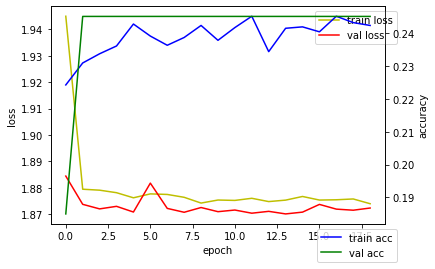

In [32]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 70)))
    model.add(LSTM(512))
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_wLSTM = eval_model(runModel('wLSTM',Model(),crossentropy, X_train, Y_train, X_valid, Y_valid), X_test, Y_test)

In [33]:
f1_score_wLSTM

0.03946002076843198

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(70)))
    #MultiCategoryEncoding
    #Normailzation
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

f1_score_DNN1 = eval_model(runModel('DNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)
f1_score_DNN1

In [37]:
label_s=vis['label']
data_s=vis.drop(['label'],axis=1)
scaler = MinMaxScaler()
scaled_s = scaler.fit_transform(data_s)
data_s = pd.DataFrame(scaled_s, columns = data_s.columns, index=data_s.index)
print(data_s.shape, label_s.shape)

trainX, testX, trainY, testY = train_test_split(data_s,label_s, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = label_s)

print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(108212, 70) (108212,)
(64927, 70) (43285, 70) (64927,) (43285,)


In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC

svm = SVC(decision_function_shape='ovr', gamma='auto')
param_distributions={'gamma':reciprocal(0.001,0.1),'C':uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm, param_distributions, 
                                   n_iter=10, verbose=2, cv=5)
rnd_search_cv.fit(trainX,trainY)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....C=9.550686704744844, gamma=0.027174543225771338; total time= 9.2min
[CV] END ....C=9.550686704744844, gamma=0.027174543225771338; total time= 9.2min
[CV] END ....C=9.550686704744844, gamma=0.027174543225771338; total time= 9.6min
[CV] END ....C=9.550686704744844, gamma=0.027174543225771338; total time= 9.6min
[CV] END ....C=9.550686704744844, gamma=0.027174543225771338; total time= 9.6min
[CV] END ....C=4.499270423055396, gamma=0.023693737191848474; total time= 9.5min
[CV] END ....C=4.499270423055396, gamma=0.023693737191848474; total time= 9.5min
[CV] END ....C=4.499270423055396, gamma=0.023693737191848474; total time= 9.7min
[CV] END ....C=4.499270423055396, gamma=0.023693737191848474; total time= 9.6min
[CV] END ....C=4.499270423055396, gamma=0.023693737191848474; total time= 9.7min
[CV] END ....C=5.126797504066838, gamma=0.011303717610068906; total time= 9.3min
[CV] END ....C=5.126797504066838, gamma=0.011303

RandomizedSearchCV(cv=5, estimator=SVC(gamma='auto'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027851EA49C8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027851DFBF88>},
                   verbose=2)

In [39]:
print(rnd_search_cv.best_estimator_, rnd_search_cv.best_score_)

SVC(C=4.499270423055396, gamma=0.023693737191848474) 0.2962402981179163


In [40]:
from sklearn.metrics import accuracy_score

rnd_search_cv.best_estimator_.fit(trainX,trainY)

y_pred = rnd_search_cv.best_estimator_.predict(trainX)
print(accuracy_score(trainY,y_pred))

y_pred = rnd_search_cv.best_estimator_.predict(testX)
print(accuracy_score(testY,y_pred))

0.2924515224790919
0.2917176851103154
